## Governing Equation: 
$$
\dfrac{d x}{d t} + 0.1t-sin(\dfrac{\pi t}{2}) = 0
$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def derivative(y,t):
    return torch.autograd.grad(
        y,t,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True
    )[0]

In [3]:
# class Sin(nn.Module):
#     def forward(self,x):
#         return torch.sin(x)

In [4]:
#Model
class PINN(nn.Module):
    def __init__(self,hidden_dim=40,hidden_layers=3):
        super(PINN, self).__init__()
        layers=[]
        layers.append(nn.Linear(1,hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim,hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim,1))
        self.net=nn.Sequential(*layers)
    def forward(self,t):
        return self.net(t)

In [5]:
#True_solution
def true_solution(t,x0=1.0):
    return -(2/np.pi)*np.cos(np.pi*t/2)-0.05*t**2 +x0
# omega=25.0
x0=1.0
t_min,t_max=0.0,3.0
device=torch.device("cpu")

In [6]:
# from scipy.integrate import solve_ivp
# def spring_rhs(t, y, omega):
#     return [y[1], -omega**2 * np.sin(y[0])]

# omega = 25.0
# x0, v0 = 0.1, 40.0
# t_span = (0, 5*np.pi/omega)
# t_dense = np.linspace(*t_span, 1001)

# sol = solve_ivp(spring_rhs, t_span, [x0, v0], t_eval=t_dense, args=(omega,))
# plt.figure(figsize=(10,4))
# #plt.plot(t_test.detach(),x_true,'k-',label="True_Solution")
# plt.plot(t_dense,sol.y[0],'r--',label="Actual_Solution")

In [7]:
#Noisy_Data_generation
np.random.seed(0)
torch.manual_seed(123)
# N_data=50
# t_data_np=np.linspace(t_min,t_max,N_data)
# x_exact=true_solution(t_data_np,x0,v0,omega)
# noise=0.9*np.random.randn(*x_exact.shape)
# x_noisy=x_exact+noise
# t_data=torch.tensor(t_data_np.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
# x_data=torch.tensor(x_noisy.reshape(-1, 1), dtype=torch.float32)

#Collocation_Points
N_f=200
t_f=torch.linspace(t_min, t_max, N_f).view(-1, 1).requires_grad_(True)
#Boundary_Points
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

In [8]:
# torch.manual_seed(123)
# t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
# t_physics = torch.linspace(0,2,100).view(-1,1).requires_grad_(True)
# N_data=50
# t_data_np=np.linspace(t_min,t_max,N_data)
# x_exact=true_solution(t_data_np,x0,v0,omega)
# noise=0.9*np.random.randn(*x_exact.shape)
# x_noisy=x_exact+noise

# t_data=torch.tensor(t_data_np.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
# x_data=torch.tensor(x_noisy.reshape(-1, 1), dtype=torch.float32)

# N_f=1000
# t_f=torch.linspace(t_min, t_max, N_f).view(-1, 1).requires_grad_(True)

In [9]:
model=PINN()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
def loss_fn():
    # u = model(t_boundary)
    # loss1 = (torch.squeeze(u) - 1)**2
    # dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    # loss2 = (torch.squeeze(dudt) - 0)**2
    # u = model(t_physics)
    # dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    # d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    # loss3 = torch.mean((d2udt2)**2)
    #Data_loss
    # x_pred_data=model(t_data)
    # loss_data=torch.mean((x_pred_data - x_data)**2)
    #Boundary_Loss
    x_pred_b=model(t_boundary)
    loss_b1=(torch.squeeze(x_pred_b) - x0)**2
    # dx_dt_b=torch.autograd.grad(x_pred_b, t_boundary, torch.ones_like(x_pred_b), create_graph=True)[0]
    # loss_b2=(torch.squeeze(dx_dt_b) - v0)**2

    #Physics_loss
    x_pred_f=model(t_f)
    dx_dt_f=derivative(x_pred_f, t_f)
    # d2x_dt2_f=derivative(dx_dt_f, t_f)
    residual=dx_dt_f + 0.1*t_f-torch.sin(torch.pi*t_f/2)
    loss_phys=torch.mean(residual**2)

    return loss_b1 + loss_phys, loss_b1.item(), loss_phys.item()



In [10]:
losses,boundary1_losses,phys_losses=[],[],[]
for epoch in range(32001):
    optimizer.zero_grad()
    loss, l_b1, l_phys=loss_fn()
    loss.backward()
    optimizer.step()
    if epoch%4000==0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.2e}, Boundary_1: {l_b1:.2e}, Phys: {l_phys:.2e}")
        losses.append(loss.item())
        boundary1_losses.append(l_b1)
        # boundary2_losses.append(l_b2)
        phys_losses.append(l_phys)



Epoch 0, Total Loss: 2.04e+00, Boundary_1: 1.45e+00, Phys: 5.83e-01
Epoch 4000, Total Loss: 1.03e-06, Boundary_1: 2.79e-09, Phys: 1.03e-06
Epoch 8000, Total Loss: 3.24e-04, Boundary_1: 3.18e-04, Phys: 6.08e-06
Epoch 12000, Total Loss: 2.01e-07, Boundary_1: 4.23e-09, Phys: 1.97e-07
Epoch 16000, Total Loss: 2.75e-07, Boundary_1: 1.16e-07, Phys: 1.59e-07
Epoch 20000, Total Loss: 7.31e-08, Boundary_1: 9.28e-09, Phys: 6.38e-08
Epoch 24000, Total Loss: 2.07e-06, Boundary_1: 8.12e-07, Phys: 1.26e-06
Epoch 28000, Total Loss: 1.57e-04, Boundary_1: 7.75e-05, Phys: 7.93e-05
Epoch 32000, Total Loss: 5.48e-08, Boundary_1: 5.40e-10, Phys: 5.43e-08


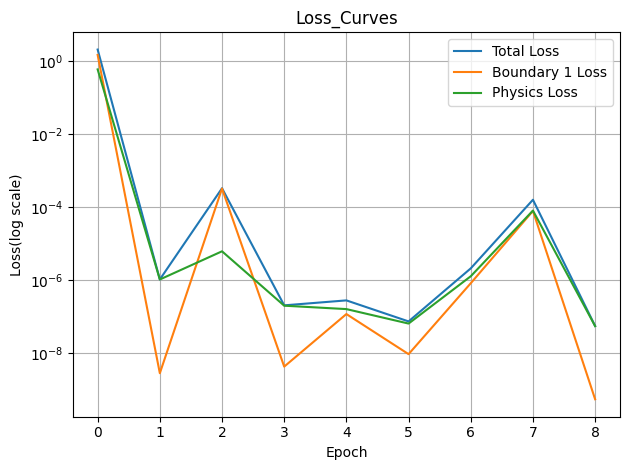

In [11]:
plt.plot(np.array(losses),label="Total Loss")
plt.plot(np.array(boundary1_losses),label="Boundary 1 Loss")
# plt.plot(np.array(boundary2_losses),label="Boundary 2 Loss")
plt.plot(np.array(phys_losses),label="Physics Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss(log scale)")
plt.title("Loss_Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

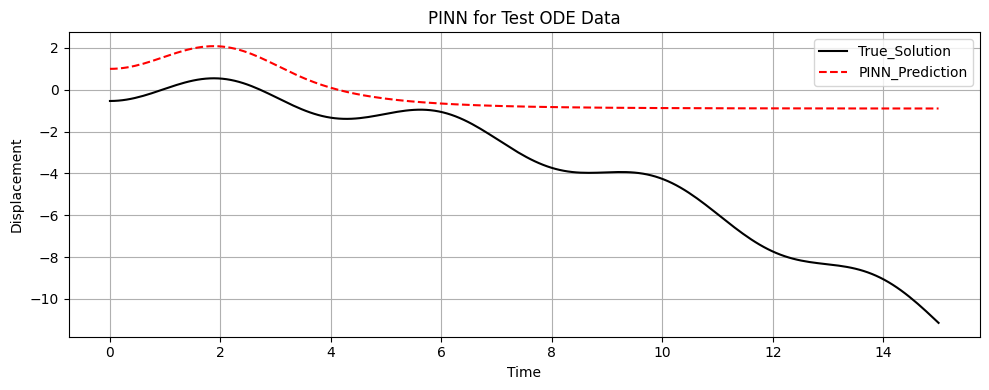

In [14]:
#Evaluation
t_test = torch.linspace(t_min, 15.0, 200).view(-1,1).requires_grad_(True)
x_pred = model(t_test).detach().numpy()
x_true = true_solution(t_test.detach().numpy().flatten(), x0)

plt.figure(figsize=(10,4))
plt.plot(t_test.detach(),x_true,'k-',label="True_Solution")
plt.plot(t_test.detach(),x_pred,'r--',label="PINN_Prediction")
#plt.scatter(t_data.detach(),x_data.detach(),c='blue',label="Noisy_Data_Points",s=30,alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.title("PINN for Test ODE Data")
plt.grid(True)
plt.tight_layout()
plt.show()

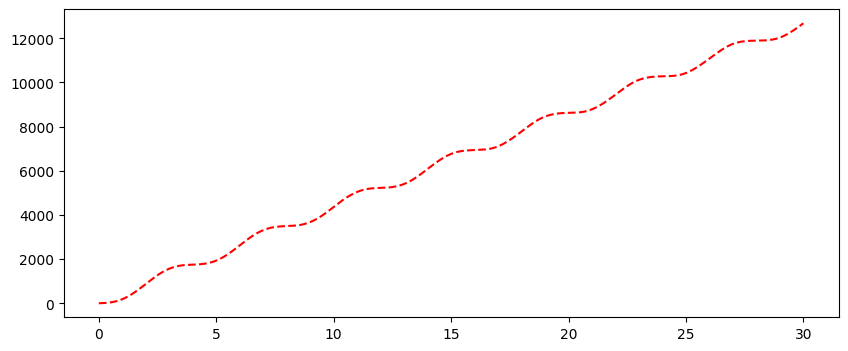

In [16]:
from scipy.integrate import solve_ivp
def spring_rhs(t, y, omega):
    return [y[1],-0.1*t+omega**2 * np.sin(np.pi*t/2)]

omega = 25.0
x0, v0 = 0.1, 40.0
t_span = (0, 30.0)
t_dense = np.linspace(*t_span, 1001)

sol = solve_ivp(spring_rhs, t_span, [x0, v0], t_eval=t_dense, args=(omega,))
plt.figure(figsize=(10,4))
#plt.plot(t_test.detach(),x_true,'k-',label="True_Solution")
plt.plot(t_dense,sol.y[0],'r--',label="Actual_Solution")
